# Part 1
Easy peasy

In [281]:
import numpy as np
pregrid = np.genfromtxt("input21.txt", str, comments=None, delimiter=1)
grid = np.zeros(pregrid.shape, int)
conversion = {".":0, "S":1, "#":7}
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid[i,j] = conversion[pregrid[i,j]]
del pregrid

#front and visited important to reduce repetitive computations: a plot that is visited once is determined (by parity)
front = {tuple(np.argwhere(grid==1)[0])}
visited = {tuple(np.argwhere(grid==1)[0])}
possible_final = {tuple(np.argwhere(grid==1)[0])}

for i in range(64):#or 64
    new_frt = set()
    for pt in front:
        new_frt = new_frt.union({tuple(map(sum,zip(pt,d))) for d in {(0,1), (1,0), (0,-1), (-1,0)}})# displacemts = {(0,1), (1,0), (0,-1), (-1,0)}
    front = {n for n in new_frt if grid[n]!=7 and n not in visited}
    visited = visited.union(front)
    if i%2:#even steps with odd i; on an even step, anywhere reached is a possible final point; on an odd step, nowhere is
        possible_final = possible_final.union(front)
 
len(possible_final)

3699

Visualization to help Part 2

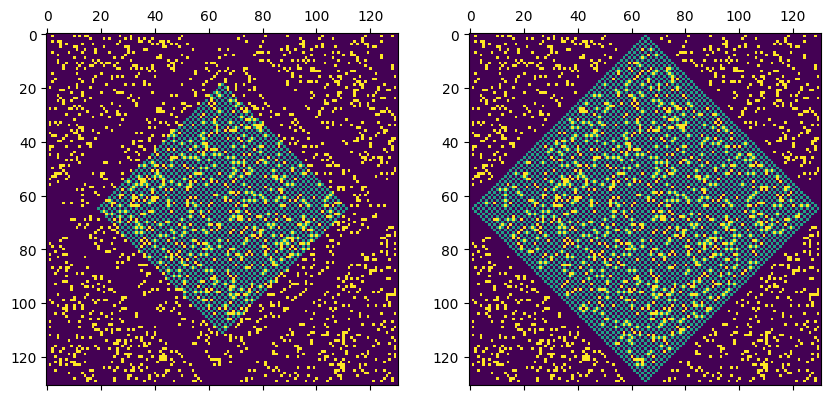

In [284]:
import matplotlib.pyplot as plt
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if (i,j) in possible_final:
            grid[i,j] = 4  
# grid46 = grid.copy()
fig, ax = plt.subplots(1,2, figsize=(10,20))
ax[0].matshow(grid46); #46 steps only
ax[1].matshow(grid);

# Part 2
Oh, boy...

Number of steps too gigantic to compute it all. But we can compute up to a certain point:

In [290]:
with open("exampleinput21.txt", "r") as f:
    grid = f.readlines()
grid = [l.removesuffix("\n") for l in grid]
v_len, h_len = len(grid), len(grid[0])

def initializer(grid):
    #find initial point (i,j)
    for i in range(len(grid)):
        if "S" in grid[i]:
            j = grid[i].index("S")
            break
    initial_point = (i,j)
    # front = {initial_point}
    # visited = {initial_point}
    # possible_final = {initial_point}
    return {initial_point}

#no caching because the front guarantees each neighbor seen only once
def neighbors_of(point, grid, v_len, h_len):
    neighbors = {tuple(map(sum,zip(point,d))) for d in {(0,1), (1,0), (0,-1), (-1,0)}}
    neighbors = {n for n in neighbors if grid[n[0]%v_len][n[1]%h_len]!="#"}
    return neighbors

n_steps = 500
front, visited, possible_final = initializer(grid), initializer(grid), set() if (n_steps%2) else initializer(grid)

for i in range(1, n_steps+1): #range chosen for i to be correct parity
    front = {n for pt in front for n in neighbors_of(pt, grid, v_len, h_len)}
    front = {n for n in front if n not in visited}
    visited = visited.union(front)
    if (n_steps-i)%2==0: #step added if same parity as total
        possible_final = possible_final.union(front)
len(possible_final)


167004

Crucially, the plots at the rim of each tile are all dots. This makes it so that once the first point of the wavefront arrives at a tile (say, at the middle of an edge), spread from there reaches the whole edge before the rest of the wavefront does or simultaneously (remember taxicab norm here, and that the first point has no obstacles because of all dots).
So the spread in each tile only depends on where its first point was. It can be center (original tile), middle of edge (tiles 1-rook-move-away from center) or corner (all others).

Also, there are straight lines from the center "S" to all edges, so the first point reached in each tile is the min-distance one, and it is reached at min-distance steps.

Let us do the evolution of each tile with different starting points until it saturates the tile. First, we define our great function to calculate it. After saturation, the only change is by parity, so even and odd sets are output by the function:

In [1]:
with open("input21.txt", "r") as f:
    grid = f.readlines()
grid = [l.removesuffix("\n") for l in grid]
v_len, h_len = len(grid), len(grid[0])

def tile_spread(grid, v_len, h_len, initial_point=(65,65), max_step="sat"):
    def neighbors_of(point, grid, v_len, h_len): #neighbors within tile only
        neighbors = {tuple(map(sum,zip(point,d))) for d in {(0,1), (1,0), (0,-1), (-1,0)}}
        neighbors = {n for n in neighbors if n[0] in range(v_len) and n[1] in range(h_len) and grid[n[0]][n[1]]!="#"}
        return neighbors #no caching because the front guarantees each neighbor seen only once

    front, visited, even_covered, odd_covered = {initial_point}, {initial_point}, {initial_point}, set()
    if max_step=="sat":
        last_step = 10**10 #effectively infinite
    else:
        last_step = max_step
    for i in range(1, last_step+1):
        front = {n for pt in front for n in neighbors_of(pt, grid, v_len, h_len)}
        front = {n for n in front if n not in visited}
        if front==set():
            break
        visited = visited.union(front)
        if i%2: #step added if same parity as total, but i is out of phase (i even for odd step)
            odd_covered = odd_covered.union(front)
        else:
            even_covered = even_covered.union(front)

    if max_step=="sat":
        return i-1, len(even_covered), len(odd_covered) #for i there's a -1 because the last step before saturation is useless
    elif max_step%2:
        return i, len(odd_covered), 0
    else:
        return i, len(even_covered), 0

Behavior after saturation depending on where tile initiated and parity:

In [2]:
steps_sat, even_cov, odd_cov = [], [], []
for initial_point in [(65,65),(65,0),(65,130),(130,65),(0,65),(130,0),(130,130),(0,130),(0,0)]:
    step, even_c, odd_c = tile_spread(grid, v_len, h_len, initial_point=initial_point)
    steps_sat.append(step); even_cov.append(even_c); odd_cov.append(odd_c)
print("9 different starting points, # of steps to saturate, then plots covered if even, then if odd")
print('center','left','right','bottom',' top ','bl_co','br_co','tr_co','tl_corner')
print(steps_sat); print(even_cov); print(odd_cov)

9 different starting points, # of steps to saturate, then plots covered if even, then if odd
center left right bottom  top  bl_co br_co tr_co tl_corner
[130, 195, 195, 195, 195, 260, 260, 260, 260]
[7521, 7467, 7467, 7467, 7467, 7521, 7521, 7521, 7521]
[7467, 7521, 7521, 7521, 7521, 7467, 7467, 7467, 7467]


Let's look at the geometry of the whole thing. The general shape is the diamond, like in part 1. This diamond grows huuuuuuge, with the border tiles partially filled. Additionally, because the tiles are 131x131 (odd), adjacent tiles have "opposite parity" when saturated: they can be centerlike or anti-centerlike. Check the <a href="https://raw.githubusercontent.com/democat3457/AdventOfCode/master/2023/resources/day21gridvis.png">image by cwongmath aka democats3457</a>:

<div><img src="https://raw.githubusercontent.com/democat3457/AdventOfCode/master/2023/resources/day21gridvis.png" width="500"/></div>

 To avoid confusion: note that it may take an even number of steps to reach a tile, like from center to 1st right, but the pictures of those two are still opposite parity, as seen by comparing the central plot of both. Calling tiles even/odd confused me, because that's independent from requiring even/odd steps to saturate it (e.g. all 1st-quadrant tiles require the same amount of steps, but alternate)

The image uses something not yet shown here: shape of partially filled tiles. Take the set of tiles right of center as an example (center tile not included). Given the diamond geometry and angle, there could be up to 2 unfinished tiles in that set. How many steps does the Elf take in the last partial tile(s)?

Because it takes him 66 steps to leave the center tile, then 131 to each next tile, we can count how many tiles are reached and how many steps remaining on partial ones.

In [3]:
total_steps = 26501365

axis_tiles = int((total_steps - 66)/131) # =202299 tiles reached to each axis, except last (not counting the center either)
#This doesn't count the last, as total_steps=66 would give 0 instead of 1

remain_steps_axis = (total_steps-66)%131 #=130 steps in incomplete traversal of last tile(s)
axis_tiles, remain_steps_axis

(202299, 130)

Since steps remaining = 130 (>65), wavefront reaches the very end of last tile, and fully traverses the one before. Checking that the parity matches we can now make the image above (instead of axis_tiles=202299, the image has axis_tiles=3).

Note that my count of axis_tiles equals the number of saturated (full) tiles on each axis, as it counts neither center nor last tile. So 4 axis_tiles full tiles on axes.

How many full tiles out of axes (in quadrants)? From the geometry, each quadrant fills a triangle with $1+2+\cdots+(n-1)$ tiles with $n=$ axis_tiles (in the image it's just 1+2, n=3). This sum equals $(n-1)n/2$ per quadrant, or $2n(n-1)$ in total, or actually 2\*axis_tiles\*(axis_tiles-1)

Adding up all full tiles -- on axes, in quadrants, the center one: $4n+2n(n-1)+1=2n(n+1)+1=n^2+(n+1)^2$

In [4]:
print("Total full tiles:",2*axis_tiles*(axis_tiles+1)+1)#=81850175401

Total full tiles: 81850175401


These alternate in being centerlike and anti-centerlike. How many of each? Well, calculating these for a few values of $n$ shows that, for odd $n$ as in our case, there are $n^2$ startlike and $(n+1)^2$ antistartlike. Their fillings can be obtained from a saturated center tile with, resp., odd and even steps.

(Shout-outs to villuna's <a href="https://github.com/villuna/aoc23/wiki/A-Geometric-solution-to-advent-of-code-2023,-day-21">helping solution</a>, though I define some numbers differently)

###### Note: center tile starts even (zero) on center (cl), first-right tile starts even on edge (anti-cl), second starts odd on edge (cl again), etc. Starting on center or corner gives same results (those are 130 apart), opposite from starting on edge (65 apart from center, corner)

In [5]:
#with above n = axis_tiles
total_plots = axis_tiles**2*odd_cov[0]+(axis_tiles+1)**2*even_cov[0] #so far
print("Total so far:",total_plots)

Total so far: 613385225379267


Now let's do the partially filled tiles. First, the end-of-axis tiles (aka diamond-corner tiles). We know we have 130 steps to fill them:

In [6]:
#130 steps beginning from each direction, let's see how many plots covered, 130 being even!
steps_axend, covered_axend = [], []
for initial_point in [(65,0),(65,130),(130,65),(0,65)]:
    step, covered, _ = tile_spread(grid, v_len, h_len, initial_point=initial_point, max_step=130)
    steps_axend.append(step); covered_axend.append(covered);
total_plots += sum(covered_axend)
print("Steps this stage:", steps_axend, "\b, covered plots:", covered_axend,"\b, total so far:",total_plots)

Steps this stage: [130, 130, 130, 130], covered plots: [5629, 5616, 5630, 5615], total so far: 613385225401757


Now out-of-axis partials (on diamond border). There are two kinds, the little filled and the very filled (big and small in image)

For the little filled, note that from the 130 steps to fill the end-of-axis tile, one can divert and use 66 to cross into the little filled tile, leaving 130-66=64 steps in it

For the very filled, go back 131 steps, so 130+131 remaining, then divert to a very filled tile, using 66 steps to cross into it, leaving 130+131-66=195 steps in it

They start on corners, so all corner starts done here

###### The even/odd classification is more confusing then helpful here, but can be made; little filled: with 64 left, starts on odd on corner (anti-sl); very filled: with 195 left, starts on even on corner (sl). In any way, we are simply going to run the steps with parity given by the amount of steps in each)

In [7]:
steps_diambord, cov_diambord = [], []
for max_step in [64, 195]:
    for initial_point in [(0,0),(0,130),(130,0),(130,130)]:
        step, covered, _ = tile_spread(grid, v_len, h_len, initial_point=initial_point, max_step=max_step)
        steps_diambord.append(step); cov_diambord.append(covered);
print("    ",steps_diambord,"\n",cov_diambord)

     [64, 64, 64, 64, 195, 195, 195, 195] 
 [963, 966, 935, 958, 6548, 6534, 6548, 6549]


How many of those are there?<br>From the geometry, we see that for each of $n$ tiles along the axis there is a very filled tile, so $n$ (or axis_tiles) of each of the four kind (start on each corner).
<br>Also from the geometry, there are $n+1$ little filled tiles in each diamond border, i.e., $n+1$ of each of the four kinds

In [8]:
total_plots += sum(cov_diambord[:4])*(axis_tiles+1)+sum(cov_diambord[4:])*axis_tiles
print("This concludes our count, thus our final total is",total_plots)

This concludes our count, thus our final total is 613391294577878


##### Alternate method: quadratic fitting

The reasoning above is valid for any odd $n$, and all dependencies on $n$ are linear or squared. As such, we can do a quadratic fitting: we calculate the value for small values of $n$ and with 3 points we can fit the parabola.

To do that, we run the full algorithm on $65+2m\times131$ steps for $m=1,2,3$ (for the full problem, $m=101150$, i.e. is $26501365=65+2\times101150\times131$)
<br>[takes approx 2 min]

In [9]:
with open("input21.txt", "r") as f:
    grid = f.readlines()
grid = [l.removesuffix("\n") for l in grid]
v_len, h_len = len(grid), len(grid[0])

def initializer(grid):
    #find initial point (i,j)
    for i in range(len(grid)):
        if "S" in grid[i]:
            j = grid[i].index("S")
            break
    initial_point = (i,j)
    return {initial_point}

def neighbors_of(point, grid, v_len, h_len):#no caching because the front guarantees each neighbor seen only once
    neighbors = {tuple(map(sum,zip(point,d))) for d in {(0,1), (1,0), (0,-1), (-1,0)}}
    neighbors = {n for n in neighbors if grid[n[0]%v_len][n[1]%h_len]!="#"}
    return neighbors

m_list = [1,2,3]
step_list = [65+2*131*m for m in m_list]
results = [m_list,[]]
for n_steps in step_list:
    front, visited = initializer(grid), initializer(grid)
    if n_steps%2:
        possible_final = set()
    else:
        possible_final = initializer(grid)
    for i in range(n_steps):
        front = {n for pt in front for n in neighbors_of(pt, grid, v_len, h_len)}
        front = {n for n in front if n not in visited}
        visited = visited.union(front)
        if (n_steps-i)%2: #step added if same parity as total, but i is out of phase (i even for odd step)
            possible_final = possible_final.union(front)
    results[1].append(len(possible_final))
print("For m in",results[0], "\b, plots covered are",results[1])

[[1, 2, 3], [93864, 303854, 633748]]

In general, this is approximately quadratic for any number of steps (grows like area), but it is exactly so for steps of the form chosen.

Let's do the quadratic regression to find $a,b,c$ in $a\ m^2+b\ m+c$

In [17]:
import numpy as np
# short_list = [list(results[0]), results[1]]
# short_list = [m_list, results[1]]

matr = np.ones((3,3), int)
matr[:,0] = (np.array(results[0],int)**2)
matr[:,1] = np.array(results[0],int)
indepterms = np.array(results[1],int)

#Solving by the Cramer method
matr_a = matr.copy()
matr_a[:,0] = indepterms
matr_b = matr.copy()
matr_b[:,1] = indepterms
matr_c = matr.copy()
matr_c[:,2] = indepterms

#defining my own det of 3x3 because numpy introduces approximation errors
def det(m):
    return m[0,0]*m[1,1]*m[2,2] + m[0,1]*m[1,2]*m[2,0] + m[0,2]*m[1,0]*m[2,1] - m[0,2]*m[1,1]*m[2,0] -m[0,1]*m[1,0]*m[2,2] - m[0,0]*m[1,2]*m[2,1] 

a, b, c = int(det(matr_a)/det(matr)), int(det(matr_b)/det(matr)), int(det(matr_c)/det(matr))
m = 101150
print("Final fitted value is", a*m**2+b*m+c, "\b, determinants of [matr, matr_a, matr_b, matr_c] are", [det(matr), det(matr_a), det(matr_b), det(matr_c)])

Final fitted value is 613391294577878, determinants of [matr, matr_a, matr_b, matr_c] are [-2, -119904, -60268, -7556]


And both values happily agree (also agree with adventofcode.com)